# House price regression

## Description of the notebook

This notebook is organized in 7 parts.

1. Data acquisition: we will import the dataset and get a first glance at what it contains.

2. Dataset exploratory analysis : we will analyze the data, get an understanding of the main features, of their types, if they have missing values...

3. Features exploratory analysis : we will analyze the data,find the corelation between the features and the survival rate and decide which features to keep

4. Data cleaning and feature selection : Select features that will be kept in the model and remove others, deal with missing values if there is any, create dummy variables for categories...

5. Model preparation : prepare the train and test set and prepare the models we will use for the classification

6. Pipeline evaluation and selection: We will run the models and get their scores, which will allow us the choose the best model.

7. Predict : Final stage, we will run our final model to execute predictions.

# 1. Data acquisition

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style('darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
dataset_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# 2. Dataset Exploratory analysis
In this section we will check the number and types of features for the dataset, if there is missing values, if there is corelation between some features, if we can remove some unnecessary features and if we can create new features from the ones we already have

In [3]:
def screen_data(df):
    rows = []
    for col in df.columns:
        rows.append([col, df[col].isnull().sum(), df[col].nunique(), df[col].dtypes])
    return pd.DataFrame(rows, columns=['Col', 'Missing values', 'Unique values', 'Type'])

In [4]:
def screen_missing_values(df, ratio=0.1, verbose=0):
    total_rows = len(df)
    total_columns = len(df.columns)
    df = screen_data(df)
    df_m = df.loc[df['Missing values'] != 0]#.sort_values(['Type', 'Missing values'])
    total_missing_values = len(df_m)
    df_m.loc[:, 'Percentage missing values'] = df_m['Missing values']/total_rows
    missing_values_less10 = len(df_m.loc[df_m['Percentage missing values'] <= ratio])
    missing_values_more10 = len(df_m.loc[df_m['Percentage missing values'] > ratio])
    print('Total missing values : ',total_missing_values, ' --> ', round(100*total_missing_values/total_columns,0), '% of all features')
    print('Columns with less than ', round(ratio*100,0),'% missing values : ',missing_values_less10, ' --> ', round(100*missing_values_less10/total_missing_values, 0), '% of features with missing values')
    print('Columns with more than ', round(ratio*100,0),'% missing values : ',missing_values_more10, ' --> ', round(100*missing_values_more10/total_missing_values, 0), '% of features with missing values')
    if(verbose >= 1):
        print("")
        print(df_m.drop(columns=['Unique values', 'Type']).loc[df_m['Percentage missing values'] > ratio])

## 2.1 Dataframe information

In [5]:
dataset_train.shape, dataset_test.shape

((1460, 81), (1459, 80))

The train and the test set are the same size, so it's going to be important not to overfit the model.

In [6]:
dataset_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [7]:
df = screen_data(dataset_train)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
Col,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Missing values,0,0,0,259,0,0,1369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,37,37,38,37,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690,81,81,81,0,0,81,81,0,0,0,0,0,0,0,1453,1179,1406,0,0,0,0,0,0
Unique values,1460,15,5,110,1073,2,2,4,4,2,5,3,25,9,8,5,8,10,9,112,61,6,8,15,16,4,327,4,5,6,4,4,4,6,637,6,144,780,721,6,5,2,5,753,417,24,861,4,3,4,3,8,4,4,12,7,4,5,6,97,3,5,441,5,5,3,274,202,120,20,76,8,3,4,4,21,12,5,9,6,663
Type,int64,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object,int64


### Missing values

In [8]:
screen_missing_values(dataset_train, verbose=1)

Total missing values :  19  -->  23.0 % of all features
Columns with less than  10.0 % missing values :  13  -->  68.0 % of features with missing values
Columns with more than  10.0 % missing values :  6  -->  32.0 % of features with missing values

            Col  Missing values  Percentage missing values
3   LotFrontage             259                   0.177397
6         Alley            1369                   0.937671
57  FireplaceQu             690                   0.472603
72       PoolQC            1453                   0.995205
73        Fence            1179                   0.807534
74  MiscFeature            1406                   0.963014


In [9]:
screen_missing_values(dataset_test, verbose=1)

Total missing values :  33  -->  41.0 % of all features
Columns with less than  10.0 % missing values :  27  -->  82.0 % of features with missing values
Columns with more than  10.0 % missing values :  6  -->  18.0 % of features with missing values

            Col  Missing values  Percentage missing values
3   LotFrontage             227                   0.155586
6         Alley            1352                   0.926662
57  FireplaceQu             730                   0.500343
72       PoolQC            1456                   0.997944
73        Fence            1169                   0.801234
74  MiscFeature            1408                   0.965045


In the dataset test there is more columns with missing values, but most of them have less than 10% missing values. <br>
The column with more than 10% missing values are the same in train and test. <br>
The columns might have missing values to indicate an absence of pool or fireplace for example, we will have to analyse things a bit more to conclude.

### Types of data

In [10]:
print('Categorical features : ', len(dataset_train.drop(columns=['Id', 'SalePrice']).select_dtypes(include='object').columns))
print('Numerical features : ', len(dataset_train.drop(columns=['Id', 'SalePrice']).select_dtypes(exclude='object').columns))
print('Total features : ', len(dataset_train.drop(columns=['Id', 'SalePrice']).columns))

Categorical features :  43
Numerical features :  36
Total features :  79


A lot of numerical and categorical data

## 2.2 Data description

Based on this very small analysis we can see that we have 79 different features. <br>
In order to start analysing we will have to choose some feature we think might give us a good aproximation of the sale price. <br>
It is not possible to carry an extensive EDA on all the features. <br>
Let's if we can drop some feature which give us the same info (abs(corr) > 0.85), or that represent the same idea.

## Let's check the document describing the data

### Columns we will analyse
- MSZoning because there is probably a difference between an agriculture zone, an industrial zone and a residential zone.
- Lot area, which is the size of the lot
- Neighborhood, probably the price is not the same depending on the neighborhood.
- OverallQual & OverallCond
- YearBuilt
- MoSold, YrSold: maybe the time of year has an impact on the price
- SaleType
- Bedroom & TotRmsAbvGrd
- TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF

### Columns we will transform
- OverallQual & OverallCond, we can probably aggregate thse columns together
- YearBuilt & YearRemodAdd
- ExterQual, ExterCond, BsmtCond, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, GarageQual, GarageCond
- TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
- TotalBath = FullBath + HalfBath + BsmtFullBath + BsmtHalfBath
- TotalPorch = WoodDeckSF + openPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

### Columns we will probably drop
- LandSlope or LandContour, because they contain the same information
- The columns with a lot of missing data, unless they provide very valuable data and we can consider that missing data is just an abscence of pool or fireplace.

# 3. Feature exploratory analysis

Let's start with two categorical data that describe the surroundings of the house MSZoning and Neighborhood.

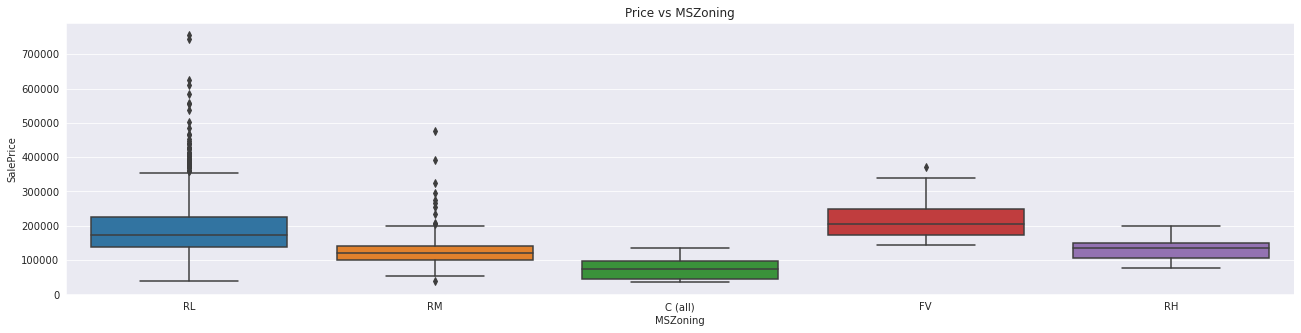

In [17]:
fig, ax = plt.subplots(1,1, figsize=(22,5))
sns.boxplot(x="MSZoning", y="SalePrice", data=dataset_train, ax=ax)
ax.set_title('Price vs MSZoning');

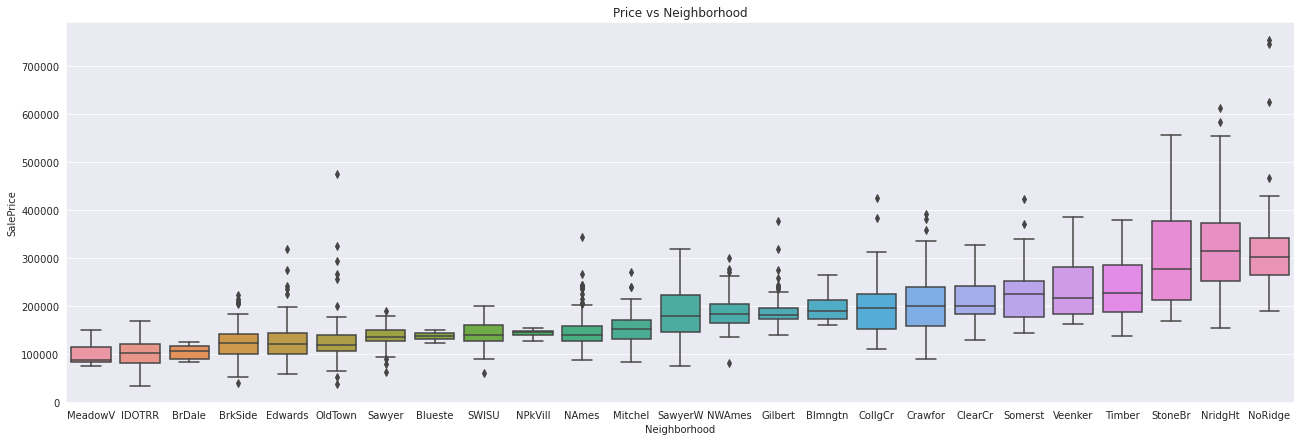

In [33]:
order = dataset_train.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice').index.to_list()
fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="Neighborhood", y="SalePrice", data=dataset_train, order=order, ax=ax)
ax.set_title('Price vs Neighborhood');

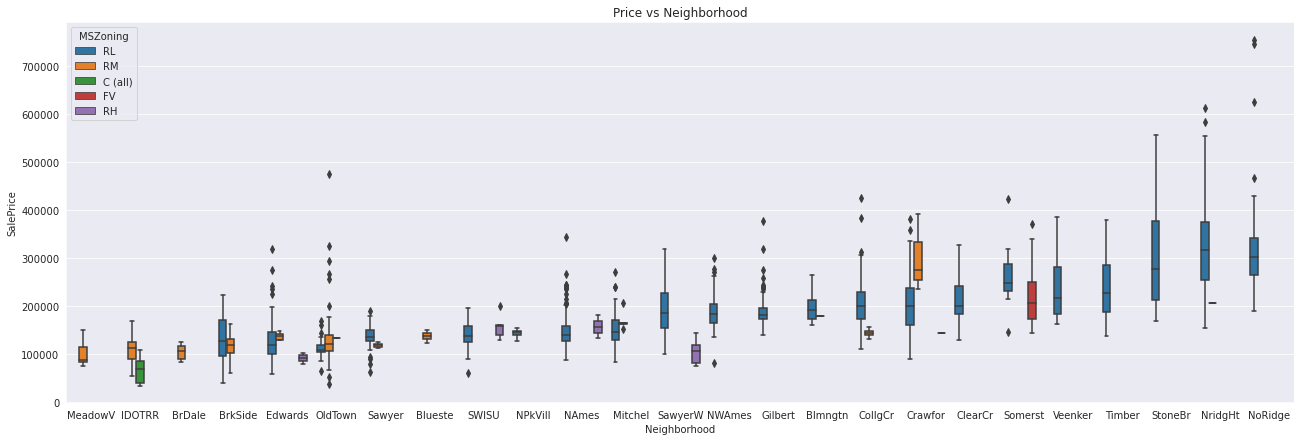

In [34]:
order = dataset_train.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice').index.to_list()
fig, ax = plt.subplots(1,1, figsize=(22,7))
sns.boxplot(x="Neighborhood", y="SalePrice", hue="MSZoning", data=dataset_train, order=order, ax=ax)
ax.set_title('Price vs Neighborhood');

#### Things we can learn from the previous analysis
- The Neighborhood seems to have a big impact on the price
- Inside a neighborhood, the price can change depending on the zone for example in Crawfor.

### Let's continue witht he size of the house
We will check the lot size and the size of the house.

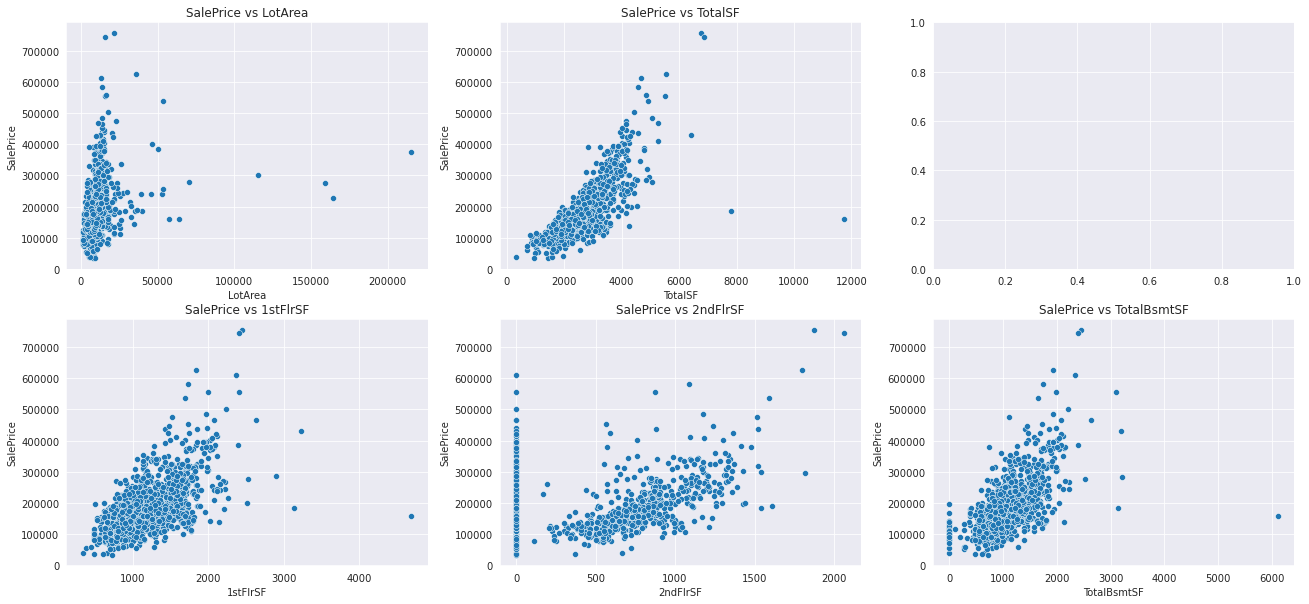

In [43]:
dataset_train['TotalSF'] = dataset_train['1stFlrSF'] + dataset_train['2ndFlrSF'] + dataset_train['TotalBsmtSF']
fig, ax = plt.subplots(2,3, figsize=(22,10))
sns.scatterplot(x="LotArea", y="SalePrice", data=dataset_train, ax=ax[0][0])
ax[0][0].set_title('SalePrice vs LotArea');
sns.scatterplot(x="TotalSF", y="SalePrice", data=dataset_train, ax=ax[0][1])
ax[0][1].set_title('SalePrice vs TotalSF');
sns.scatterplot(x="1stFlrSF", y="SalePrice", data=dataset_train, ax=ax[1][0])
ax[1][0].set_title('SalePrice vs 1stFlrSF');
sns.scatterplot(x="2ndFlrSF", y="SalePrice", data=dataset_train, ax=ax[1][1])
ax[1][1].set_title('SalePrice vs 2ndFlrSF');
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=dataset_train, ax=ax[1][2])
ax[1][2].set_title('SalePrice vs TotalBsmtSF');


#### Things we can learn from the previous analysis
- The lot area is not much correlated to the price, but maybe we can transform this column to get a better correlation (log?)
- The 1stFlrSF, 2ndFlrSF and TotalBsmtSF are correlated to the price but show an increase of the variance when the price increases.
- Summing all these values together give us a better correlation, with some outliers that we might have to remove or transform

The Neighborhood seems to have a big impact on the price

In [ ]:
#we get a list of column with more than 25 missing values
drop_list_train = columns_with_missing_data(df_train, 25)
print(drop_list_train)

In [ ]:
df_train = df_train.drop(columns = drop_list_train)
df_test = df_test.drop(columns = drop_list_train)
print(columns_with_missing_data(df_train, 25))
print(columns_with_missing_data(df_test, 25))

We have no more column with more than 25 missing values. <br>
Now let's fill the missing values with median values for each column

In [ ]:
print(columns_with_missing_data(df_train, 0))
print(columns_with_missing_data(df_test, 0))

In [ ]:
df_train = df_train.fillna(df_train.median())
df_test = df_test.fillna(df_train.median())

df_train = df_train.fillna(df_train.mode().iloc[0])
df_test = df_test.fillna(df_train.mode().iloc[0])

print(columns_with_missing_data(df_train, 0))
print(columns_with_missing_data(df_test, 0))

In [ ]:
df_train.sample(10)

In [ ]:
for feature in df_train.columns:
    if(df_train[feature].dtype == np.object):
        print(feature, '   ', df_train[feature].unique())

In [ ]:
df_train.info()

In [ ]:
corr_train = df_train.corr().iloc[[-1]]
corr_train.head()

In [ ]:
encode_col_list = list(df_train.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    df_train = pd.concat([df_train,pd.get_dummies(df_train[i], prefix=i)],axis=1)
    df_train.drop(i, axis = 1, inplace=True)
    
encode_col_list = list(df_test.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    df_test = pd.concat([df_test,pd.get_dummies(df_test[i], prefix=i)],axis=1)
    df_test.drop(i, axis = 1, inplace=True)

In [ ]:
corr_train = df_train.corr().iloc[[df_train.columns.get_loc("SalePrice")]]
corr_train.head()

In [ ]:
#get the name of all the features where the correlation with the price is between -0.5 and 0.5 
drop_feature = corr_train[abs(corr_train[corr_train.columns]) < 0.5].dropna(axis='columns').columns
drop_feature

In [ ]:
df_train = df_train.drop(columns=drop_feature, errors='ignore')
df_test = df_test.drop(columns=drop_feature, errors='ignore')
corr_train = df_train.corr().iloc[[df_train.columns.get_loc("SalePrice")]]
corr_train.head()

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
X = df_train.drop(columns=['SalePrice'])
y = np.array([df_train['SalePrice']]).T

X_pred = df_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
regressor_linear_regression = LinearRegression()
regressor_linear_regression.fit(X_train, y_train)

y_pred_linear_regression = regressor_linear_regression.predict(X_test)

In [ ]:
#poly_reg = PolynomialFeatures(degree = 4)
#X_poly = poly_reg.fit_transform(X_train)
#regressor_polynomial_regression = LinearRegression()
#regressor_polynomial_regression.fit(X_poly, y_train)

#y_pred_polynomial_regression = regressor_polynomial_regression.predict(poly_reg.transform(X_test))

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()
y_train_reshaped = y_train.reshape(len(y_train),1)
X_train_scaled = sc_X.fit_transform(X_train)
y_train_scaled = sc_y.fit_transform(y_train_reshaped)

regressor_svr = SVR(kernel = 'rbf')
regressor_svr.fit(X_train_scaled, y_train_scaled)

y_pred_svr = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))

In [ ]:
regressor_decision_tree = DecisionTreeRegressor(random_state = 0)
regressor_decision_tree.fit(X_train, y_train)

y_pred_decision_tree = regressor_decision_tree.predict(X_test)

In [ ]:
regressor_random_forest = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_random_forest.fit(X_train, y_train)

y_pred_random_forest = regressor_random_forest.predict(X_test)

In [ ]:
data = [['Multiple linear regression', r2_score(y_test, y_pred_linear_regression), max_error(y_test, y_pred_linear_regression), mean_absolute_error(y_test, y_pred_linear_regression), mean_squared_error(y_test, y_pred_linear_regression), mean_squared_log_error(y_test, y_pred_linear_regression)],
#['Polynomial regression', r2_score(y_test, y_pred_polynomial_regression), max_error(y_test, y_pred_polynomial_regression), mean_absolute_error(y_test, y_pred_polynomial_regression), mean_squared_error(y_test, y_pred_polynomial_regression), mean_squared_log_error(y_test, y_pred_polynomial_regression)],
['Support vector regression', r2_score(y_test, y_pred_svr), max_error(y_test, y_pred_svr), mean_absolute_error(y_test, y_pred_svr), mean_squared_error(y_test, y_pred_svr), mean_squared_log_error(y_test, y_pred_svr)],
['Decision tree', r2_score(y_test, y_pred_decision_tree), max_error(y_test, y_pred_decision_tree), mean_absolute_error(y_test, y_pred_decision_tree), mean_squared_error(y_test, y_pred_decision_tree), mean_squared_log_error(y_test, y_pred_decision_tree)],
['Random forest regression', r2_score(y_test, y_pred_random_forest), max_error(y_test, y_pred_random_forest), mean_absolute_error(y_test, y_pred_random_forest), mean_squared_error(y_test, y_pred_random_forest), mean_squared_log_error(y_test, y_pred_random_forest)]] 
headers_1=["1", "2", "3", "4"] 
headers_2=["Algorithm", "R² score", "Max err", "Mean Abs err", "mean sqr err", 'root mean sqr log err'] 
print(pd.DataFrame(data, headers_1, headers_2))

We select the random forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
y_pred = rf_random.predict(X_pred)

output = pd.DataFrame({'Id': pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv").Id, 'SalePrice': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")